## Setup and Imports

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import IsolationForest as Iso
from kneed import KneeLocator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## Data Loading and Exploration

### Load and Inspect the Dataset

In [35]:
df = pd.read_csv("samiwatches.csv")

In [36]:
print("Dataset size:", df.shape)

Dataset size: (1670, 42)


In [37]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1670 non-null   object 
 1   MARKA                          1670 non-null   object 
 2   KOLEKSIYON                     1670 non-null   object 
 3   price                          1670 non-null   float64
 4   price_category                 1670 non-null   object 
 5   CINSIYET                       1670 non-null   object 
 6   MEKANIZMA                      1670 non-null   object 
 7   KASA MATERYALI                 1670 non-null   object 
 8   case_material_category         1670 non-null   object 
 9   KASA ÇAPI                      1670 non-null   object 
 10  SU REZISTANSI                  1669 non-null   object 
 11  water_resistance_category      1670 non-null   object 
 12  brand_country                  16

### Exploratory Data Analysis

In [38]:
print("\nNumerical statistics:")
print(df.describe())


Numerical statistics:
              price    brand_age         page  brand_founded_year  \
count  1.670000e+03  1253.000000  1670.000000         1253.000000   
mean   3.500409e+05   163.833998    11.708383         1860.166002   
std    5.525988e+05    38.660803     6.532354           38.660803   
min    1.380000e+04    44.000000     1.000000         1791.000000   
25%    9.100000e+04   159.000000     6.000000         1832.000000   
50%    1.742000e+05   171.000000    12.000000         1853.000000   
75%    4.066000e+05   192.000000    17.000000         1865.000000   
max    7.321600e+06   233.000000    23.000000         1980.000000   

       brand_avg_price  brand_median_price  brand_price_std  \
count     1.670000e+03        1.670000e+03     1.668000e+03   
mean      3.500409e+05        2.778319e+05     2.242556e+05   
std       4.033584e+05        2.844407e+05     3.144471e+05   
min       3.011385e+04        2.609000e+04     1.345679e+04   
25%       1.264010e+05        1.202000e+

In [39]:
print("\nMissing value counts:")
print(df.isnull().sum())


Missing value counts:
name                               0
MARKA                              0
KOLEKSIYON                         0
price                              0
price_category                     0
CINSIYET                           0
MEKANIZMA                          0
KASA MATERYALI                     0
case_material_category             0
KASA ÇAPI                          0
SU REZISTANSI                      1
water_resistance_category          0
brand_country                      0
brand_age                        417
collection_price_tier              0
url                                0
image                              0
page                               0
scraped_at                         0
AILE                             973
GARANTI SÜRESI                     5
GÜÇ REZERVI                      493
KADRAN                             0
KAYIŞ                              0
PRODUCT_NAME_DETAIL                0
PRODUCT_PRICE_DETAIL               0
REFERANS       

#### Correlation Matrix


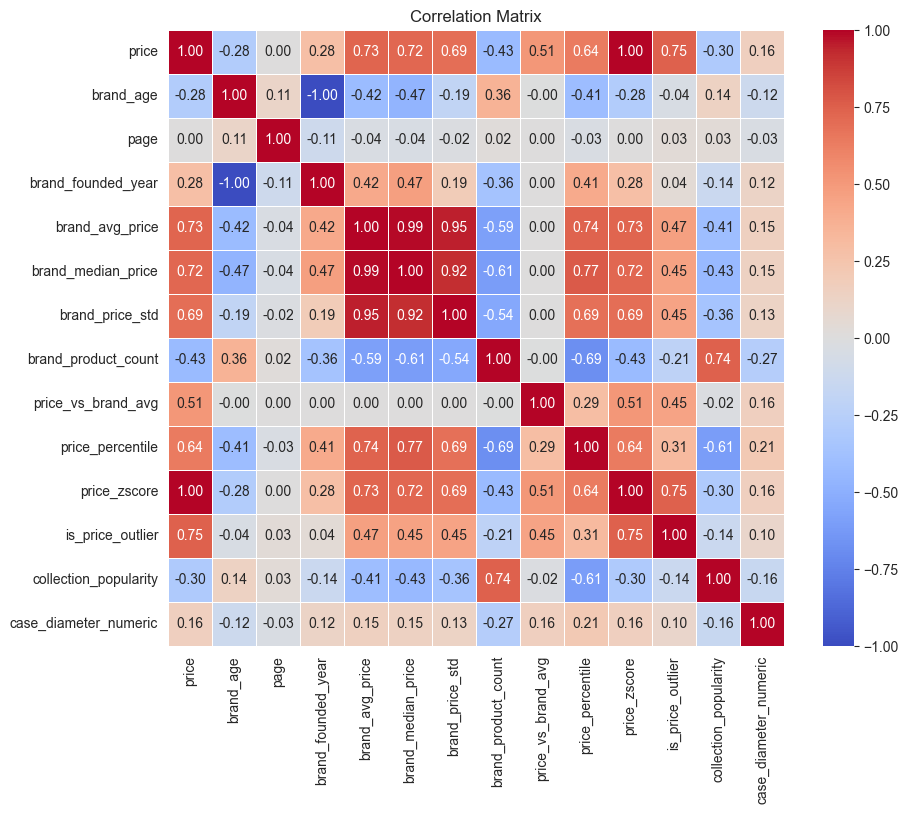

In [40]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",center=0, square=True, linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title("Correlation Matrix")
plt.show()

## Data Preprocessing


#### Data Cleaning

In [41]:
# drop unnecessary columns
to_drop = [
    # leakage
    'brand_avg_price', 'brand_median_price', 'brand_price_std', 'brand_product_count',
    'price_vs_brand_avg', 'price_percentile', 'price_zscore', 'is_price_outlier',
    'collection_price_tier', 'price_category_improved','price_category','KOLEKSIYON',

    # noise
    'name', 'url', 'image', 'scraped_at', 'page', 'PRODUCT_NAME_DETAIL', 'PRODUCT_PRICE_DETAIL',
    'REFERANS', 'AILE', 'GÜÇ REZERVI',

    # redundant
    'brand_founded_year', 'KASA MATERYALI', 'SU REZISTANSI', 'water_resistance_category',
    'KASA ÇAPI', 'case_size_category'
]

df_model = df.drop(columns=to_drop)

In [42]:
# column renaming
rename_map = {
    'MARKA': 'brand',
    'price': 'price',
    'CINSIYET': 'gender',
    'MEKANIZMA': 'movement',
    'case_material_category': 'case_material_category',
    'brand_country': 'brand_country',
    'brand_age': 'brand_age',
    'GARANTI SÜRESI': 'warranty_period',
    'KADRAN': 'dial_color',
    'KAYIŞ': 'strap_material',
    'collection_popularity': 'collection_popularity',
    'water_resistance_standardized': 'water_resistance_meters',
    'case_diameter_numeric': 'case_diameter_mm',
    'brand_prestige_level': 'brand_prestige_level'
}

df_model = df_model.rename(columns=rename_map)

In [43]:
df_model['warranty_period'] = df_model['warranty_period'].astype(str).str.extract(r'(\d+)').astype(float)

# mappings
maps = {
    'brand': {'Diğer Markalar': 'other_brands'},
    'gender': {'Erkek': 'male', 'Kadın': 'female', 'Erkek, Kadın': 'unisex'},
    'movement': {'Otomatik': 'automatic', 'Pilli': 'quartz', 'Elle Kurmalı': 'manual', 'Kurmalı': 'manual'},
    'case_material_category': {
        'Paslanmaz Çelik': 'stainless_steel', 'Çelik': 'steel', 'Altın': 'gold',
        'Titanyum': 'titanium', 'Seramik': 'ceramic', 'Karbon': 'carbon', 'Bronz': 'bronze'
    },
    'strap_material': {
        'Paslanmaz Çelik': 'stainless_steel', 'Krokodil': 'crocodile', 'Deri': 'leather',
        'Kauçuk': 'rubber', 'Tekstil': 'textile', 'Sentetik': 'synthetic', 'Silikon': 'silicone',
        'Dana Derisi': 'calfskin', 'Pembe Altın': 'rose_gold', 'Titanyum': 'titanium',
        'Altın': 'gold', 'Seramik': 'ceramic', 'Çelik Altın': 'steel_gold',
        'Kauçuk, Paslanmaz Çelik': 'rubber, stainless_steel'
    },
    'dial_color': {
        'Mavi': 'blue', 'Gümüş': 'silver', 'Siyah': 'black', 'Gri': 'grey', 'Sedef': 'mother_of_pearl',
        'Yeşil': 'green', 'İskelet': 'skeleton', 'Somon': 'salmon', 'Bej': 'beige', 'Şampanya': 'champagne',
        'Bordo': 'burgundy', 'Mor': 'purple', 'Sarı': 'yellow', 'Antrasit': 'anthracite', 'Beyaz': 'white',
        'Kahverengi': 'brown', 'Çok Renkli': 'multicolor', 'Terakota': 'terracotta', 'Pembe': 'pink',
        'Kırmızı': 'red', 'Turuncu': 'orange', 'Leopar': 'leopard',
        'Bakır': 'copper'
    },
    'brand_country': {
        'Switzerland': 'switzerland','Germany': 'germany', 'Italy': 'italy', 'Unknown': 'unknown'
    }
}

# fixing text format and apply categorical mapping
for col, mapping in maps.items():
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(str).str.lower().str.strip()
        lower_mapping = {str(k).lower().strip(): v.lower().strip() for k, v in mapping.items()}
        df_model[col] = df_model[col].replace(lower_mapping)

In [44]:
# convert unknown strings to actual NaNs
unknown_values = ['Unknown', 'unknown', 'Bilinmiyor', 'None', 'nan', '', ' ', 'Belirtilmemiş', '-']
df_model = df_model.replace(unknown_values, np.nan)

In [45]:
# target encoding
prestige_map = {
    'Giriş Seviyesi': 1,
    'Orta Prestij': 2,
    'Prestijli': 3,
    'Çok Prestijli': 4,
    'Ultra Prestijli': 5
}
df_model['brand_prestige_level'] = df_model['brand_prestige_level'].map(prestige_map)

In [46]:
# detecting brands with missing country data
brands_snapshot = df[['MARKA']].copy()
unknown_mask = df['brand_country'].isin(unknown_values)
missing_brands_report = brands_snapshot[unknown_mask]['MARKA'].unique().tolist()
print(missing_brands_report)

['H. Moser & Cie.', 'Tag Heuer', 'Bell & Ross', 'Oris', 'Bovet', 'Rado', 'Sevenfriday', 'Diğer Markalar', 'Corum']


In [47]:
# intelligent data enrichment & domain-based imputation
observed_mapping = df_model.dropna(subset=['brand_country']).set_index('brand')['brand_country'].to_dict()

manual_country_fix = {
    'h. moser & cie.': 'switzerland',
    'tag heuer': 'switzerland',
    'bell & ross': 'france',
    'oris': 'switzerland',
    'bovet': 'switzerland',
    'rado': 'switzerland',
    'sevenfriday': 'switzerland',
    'corum': 'switzerland',
    'other_brands': 'switzerland' # Majority of boutique/independent luxury brands are Swiss-based
    # NOTE: "Diğer Markalar" renamed to "other_brands"
}

final_brand_map = {**manual_country_fix, **observed_mapping}

# apply enrichment: Replace NaNs using the brand-to-country mapping
df_model['brand_country'] = df_model['brand_country'].fillna(df_model['brand'].map(final_brand_map))

# validation
print(f"Null values in 'brand_country' after Enrichment: {df_model['brand_country'].isnull().sum()}")



Null values in 'brand_country' after Enrichment: 0


In [48]:
# imputation
# calculate global safety nets
overall_age_median = df_model["brand_age"].median()
overall_warranty_mode = df_model["warranty_period"].mode()[0]

# fill brand age (Group Median then Global Median)
df_model["brand_age"] = df_model.groupby("brand")["brand_age"].transform(
    lambda x: x.fillna(x.median()) if x.notna().any() else x
)
df_model["brand_age"] = df_model["brand_age"].fillna(overall_age_median)

# fill Warranty Period (Group Mode then Global Mode)
df_model["warranty_period"] = df_model.groupby("brand")["warranty_period"].transform(
    lambda x: x.fillna(x.mode()[0]) if x.notna().any() else x
)
df_model["warranty_period"] = df_model["warranty_period"].fillna(overall_warranty_mode)

# extract digits and convert to numeric
df_model['water_resistance_meters'] = pd.to_numeric(
    df_model['water_resistance_meters'].astype(str).str.extract(r'(\d+)')[0],
    errors='coerce'
)
# water resistance: fill residual nulls using Global Median
df_model['water_resistance_meters'] = df_model['water_resistance_meters'].fillna(df_model['water_resistance_meters'].median())

In [49]:
# drop brand names after country enrichment to prevent data leakage
df_clean = df_model.drop(columns=['brand'])

#### Inspecting the data after cleaning

In [50]:
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    1670 non-null   float64
 1   gender                   1670 non-null   object 
 2   movement                 1670 non-null   object 
 3   case_material_category   1670 non-null   object 
 4   brand_country            1670 non-null   object 
 5   brand_age                1670 non-null   float64
 6   warranty_period          1670 non-null   float64
 7   dial_color               1670 non-null   object 
 8   strap_material           1670 non-null   object 
 9   collection_popularity    1670 non-null   float64
 10  water_resistance_meters  1670 non-null   float64
 11  case_diameter_mm         1670 non-null   float64
 12  brand_prestige_level     1670 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 169.7+ KB
None


In [51]:
# analyzing unique value counts
summary_table = pd.DataFrame({
    'Data Type': df_clean.dtypes,
    'Unique Count': df_clean.nunique()
})
summary_table = summary_table.sort_values(by='Unique Count', ascending=False)
print("=== Dataset Summary Table ===")
print(summary_table)

=== Dataset Summary Table ===
                        Data Type  Unique Count
price                     float64           711
case_diameter_mm          float64            52
collection_popularity     float64            38
dial_color                 object            23
strap_material             object            14
brand_age                 float64            11
case_material_category     object             6
brand_prestige_level        int64             5
water_resistance_meters   float64             5
brand_country              object             4
warranty_period           float64             4
gender                     object             3
movement                   object             3


#### Encoding and Splitting the Data


In [52]:
target_name = 'brand_prestige_level'
x_temp = df_clean.drop(columns=[target_name])

categorical_features = x_temp.select_dtypes(include=["object"]).columns

encoder = OneHotEncoder(drop = "first", sparse_output=False)
encoded_categorical = encoder.fit_transform(df_clean[categorical_features])

encoded_columns = encoder.get_feature_names_out(categorical_features)
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoded_columns)

df_clean_encoded = pd.concat([df_clean.drop(categorical_features, axis=1).reset_index(drop=True),
                          encoded_categorical_df.reset_index(drop=True)], axis=1)

x = df_clean_encoded.drop(columns=[target_name])
y = df_clean_encoded[target_name]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

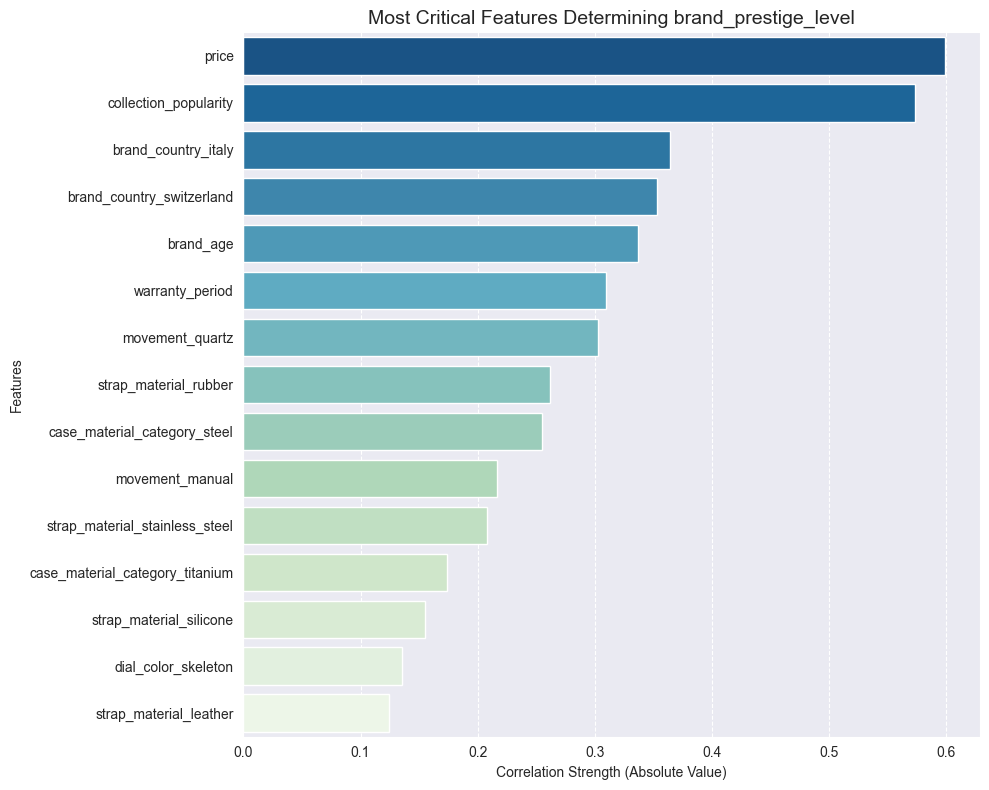

In [53]:
# Target Correlation Ranking
plt.figure(figsize=(10, 8))

corrs = df_clean_encoded.corr()[target_name].abs().sort_values(ascending=False).drop(target_name)

top_15 = corrs.head(15)

sns.barplot(
    x=top_15.values,
    y=top_15.index,
    hue=top_15.index,
    palette='GnBu_r',
    legend=False
)
plt.title("Most Critical Features Determining brand_prestige_level", fontsize=14)
plt.xlabel("Correlation Strength (Absolute Value)")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

#### Detecting and Handling Outliers


In [54]:
# training the draft model (for contamination hyperparameter tuning)
draft_model = Iso(n_estimators=100, contamination="auto", random_state=42)
draft_model.fit(x_train)

# sort the decision scores in descending order
sorted_scores = np.sort(draft_model.decision_function(x_train))
x = np.arange(len(sorted_scores))

print(pd.Series(sorted_scores).describe())

# NOTE: lower scores were assigned to those that were easier to isolate(outliers)
# for higher scored points: This data point lies in such a densely populated region that the algorithm struggled to isolate it. Therefore, they represent more typical, standard, and reliable examples in the dataset and Iso, gave higher scores to these data points

count    1336.000000
mean        0.090691
std         0.037966
min        -0.047481
25%         0.065045
50%         0.099391
75%         0.119948
max         0.160908
dtype: float64


In [55]:
knee = KneeLocator(x, sorted_scores, curve='concave', direction='increasing')

# ideal contamination for the model
ideal_contamination = knee.knee / len(sorted_scores)
print("ideal contamination:", ideal_contamination)

# NOTE: direction='increasing' (scores are sorted in ascending order)
# curve='concave' (The difference between min and Q1 is greater than the difference between Q3 and max)

ideal contamination: 0.020958083832335328


In [56]:
final_model = Iso(n_estimators=100, contamination=ideal_contamination, random_state=42)
predictions = final_model.fit_predict(x_train)
print(pd.Series(predictions).value_counts())

 1    1308
-1      28
Name: count, dtype: int64


In [57]:
# original train data sizes
print(len(x_train), len(y_train))

x_train_cleaned = x_train[predictions == 1].reset_index(drop=True)
y_train_cleaned = y_train[predictions == 1].reset_index(drop=True)

# cleaned train data sizes
print(len(x_train_cleaned), len(y_train_cleaned))

1336 1336
1308 1308


## Model Selection

#### k-NN

In [58]:
pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

parameters_knn = {"knn__n_neighbors": [3, 5, 11, 21, 31, 45, 61],
              'knn__weights': ['uniform', 'distance'],
              'knn__metric': ['euclidean', 'manhattan']}

grid_search_knn = GridSearchCV(pipeline_knn, parameters_knn, cv=5, scoring="f1_weighted", verbose=1)
grid_search_knn.fit(x_train_cleaned, y_train_cleaned)

print("Best parameters:", grid_search_knn.best_params_)
print("Best training score:", grid_search_knn.best_score_)
print("Test Score:", grid_search_knn.score(x_test, y_test))

best_knn_model = grid_search_knn.best_estimator_
y_test_pred = best_knn_model.predict(x_test)
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best training score: 0.8088739261755329
Test Score: 0.822991188116017
              precision    recall  f1-score   support

           1       0.89      0.89      0.89        66
           2       0.75      0.85      0.80       107
           3       0.77      0.81      0.79        58
           4       0.90      0.80      0.84        88
           5       1.00      0.53      0.70        15

    accuracy                           0.82       334
   macro avg       0.86      0.78      0.80       334
weighted avg       0.83      0.82      0.82       334



#### SVM

In [59]:
pipeline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True))
])

parameters_svm = {"svm__C": [3, 5, 11, 21, 31, 45, 61],
              'svm__kernel': ["rbf", "linear"],
              'svm__gamma': ["scale", "auto"]}

grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=5, scoring="f1_weighted", verbose=1)
grid_search_svm.fit(x_train_cleaned, y_train_cleaned)

print("Best parameters:", grid_search_svm.best_params_)
print("Best training score:", grid_search_svm.best_score_)
print("Test Score:", grid_search_svm.score(x_test, y_test))

best_svm_model = grid_search_svm.best_estimator_
y_test_pred = best_svm_model.predict(x_test)
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best parameters: {'svm__C': 61, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best training score: 0.9462210912389606
Test Score: 0.933586749190573
              precision    recall  f1-score   support

           1       0.97      1.00      0.99        66
           2       0.94      0.96      0.95       107
           3       0.90      0.91      0.91        58
           4       0.92      0.89      0.90        88
           5       0.92      0.80      0.86        15

    accuracy                           0.93       334
   macro avg       0.93      0.91      0.92       334
weighted avg       0.93      0.93      0.93       334



#### Naive Bayes

In [60]:
pipeline_nb = Pipeline([
    ("nb", GaussianNB())
])

parameters_nb = {
    "nb__var_smoothing": [1e-9, 1e-8, 1e-7]
}

grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring="f1_weighted", verbose=1)
grid_search_nb.fit(x_train_cleaned, y_train_cleaned)

print("Best parameters:", grid_search_nb.best_params_)
print("Best training score:", grid_search_nb.best_score_)
print("Test Score:", grid_search_nb.score(x_test, y_test))

best_nb_model = grid_search_nb.best_estimator_
y_test_pred = best_nb_model.predict(x_test)
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'nb__var_smoothing': 1e-09}
Best training score: 0.7262053985372865
Test Score: 0.705722080742729
              precision    recall  f1-score   support

           1       0.98      0.89      0.94        66
           2       0.78      0.91      0.84       107
           3       0.39      0.60      0.48        58
           4       0.79      0.42      0.55        88
           5       0.62      0.53      0.57        15

    accuracy                           0.71       334
   macro avg       0.71      0.67      0.67       334
weighted avg       0.75      0.71      0.71       334



#### Random Forest

In [61]:
pipeline_rf = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])

parameters_rf = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__criterion": ["gini", "entropy"]
}

grid_search_rf = GridSearchCV(pipeline_rf, parameters_rf, cv=5, scoring="f1_weighted", verbose=1)
grid_search_rf.fit(x_train_cleaned, y_train_cleaned)

print("Best parameters:", grid_search_rf.best_params_)
print("Best training score:", grid_search_rf.best_score_)
print("Test Score:", grid_search_rf.score(x_test, y_test))

best_rf_model = grid_search_rf.best_estimator_
y_test_pred = best_rf_model.predict(x_test)
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best training score: 0.9885264774636184
Test Score: 0.9880422968815293
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        66
           2       1.00      0.99      1.00       107
           3       0.97      0.97      0.97        58
           4       0.98      0.99      0.98        88
           5       1.00      1.00      1.00        15

    accuracy                           0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334



#### Confusion Matrices

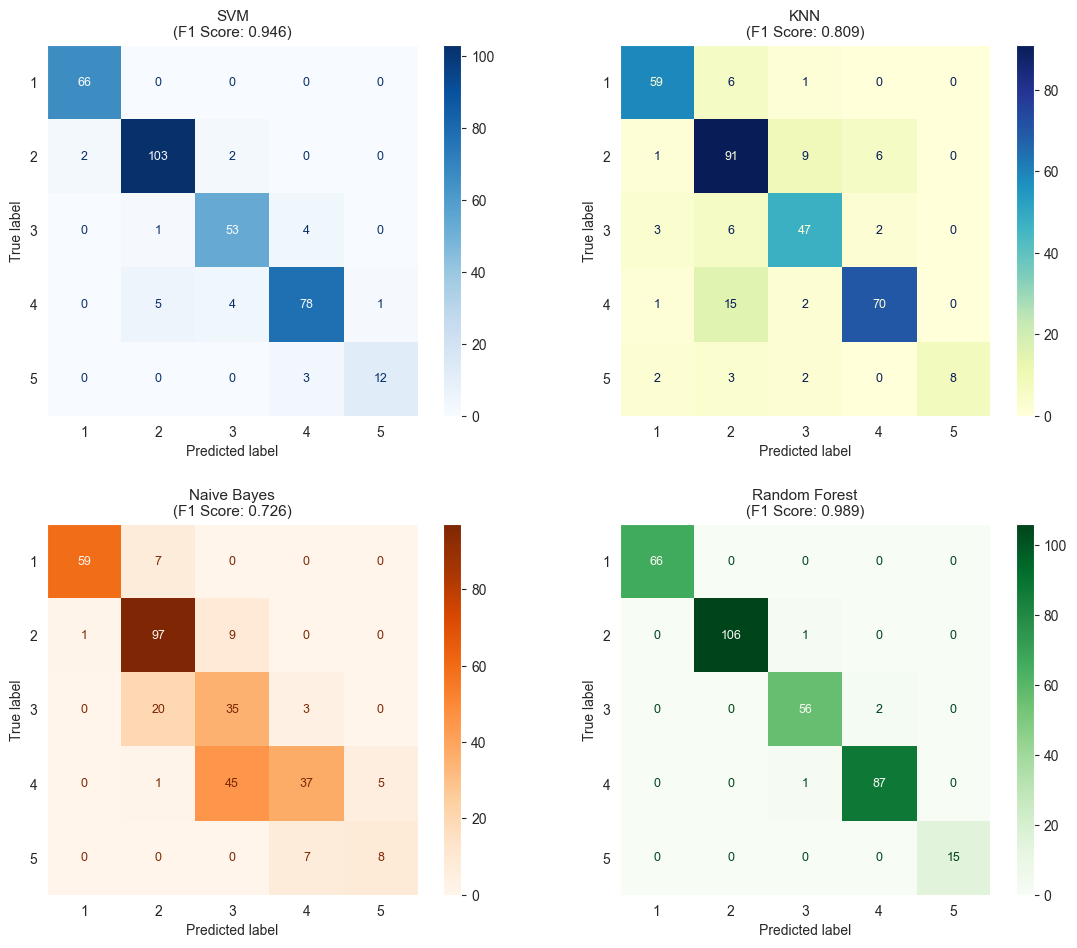

In [62]:
y_pred_knn = grid_search_knn.best_estimator_.predict(x_test)
y_pred_svm = grid_search_svm.best_estimator_.predict(x_test)
y_pred_nb = grid_search_nb.best_estimator_.predict(x_test)
y_pred_rf = grid_search_rf.best_estimator_.predict(x_test)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
t_fs = 11
l_fs = 10
n_fs = 9

# SVM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax[0,0], cmap='Blues', colorbar=True, text_kw={'fontsize': n_fs})
ax[0,0].set_title(f"SVM\n(F1 Score: {grid_search_svm.best_score_:.3f})", fontsize=t_fs)
ax[0,0].grid(False)

# KNN
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, ax=ax[0,1], cmap='YlGnBu', colorbar=True, text_kw={'fontsize': n_fs})
ax[0,1].set_title(f"KNN\n(F1 Score: {grid_search_knn.best_score_:.3f})", fontsize=t_fs)
ax[0,1].grid(False)

# Naive Bayes
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=ax[1,0], cmap='Oranges', colorbar=True, text_kw={'fontsize': n_fs})
ax[1,0].set_title(f"Naive Bayes\n(F1 Score: {grid_search_nb.best_score_:.3f})", fontsize=t_fs)
ax[1,0].grid(False)

# Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1,1], cmap='Greens', colorbar=True, text_kw={'fontsize': n_fs})
ax[1,1].set_title(f"Random Forest\n(F1 Score: {grid_search_rf.best_score_:.3f})", fontsize=t_fs)
ax[1,1].grid(False)

for a in ax.flat:
    a.xaxis.label.set_size(l_fs)
    a.yaxis.label.set_size(l_fs)
    a.tick_params(labelsize=l_fs)

plt.tight_layout(pad=3.0)
plt.show()

#### ROC Curve & AUC

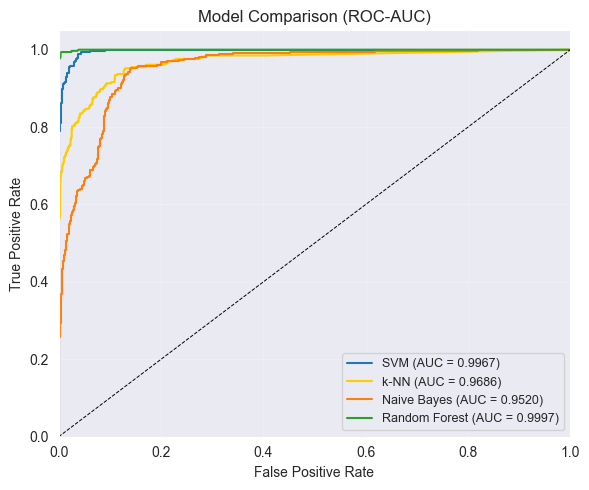

In [63]:
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

models = [
    (grid_search_svm.best_estimator_, 'SVM', '#1f77b4'),
    (grid_search_knn.best_estimator_, 'k-NN', '#ffcc00'),
    (grid_search_nb.best_estimator_, 'Naive Bayes', '#ff7f0e'),
    (grid_search_rf.best_estimator_, 'Random Forest', '#2ca02c')
]
plt.figure(figsize=(6, 5))

for model, name, color in models:
    y_score = model.predict_proba(x_test) if hasattr(model, "predict_proba") else model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=1.5, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title('Model Comparison (ROC-AUC)', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

Conclusion: Among the models tested within the scope of this project, "Random Forest" has been selected as the most reliable and successful model, as it achieved the highest scores in statistical metrics (AUC, F1) and provided the cleanest distribution in the confusion matrix.